# FS2024: 21109 Privacy and Data Security - Exercise 09

## Differentially Private Machine Learning

### Installing libraries

Before starting, make sure you have the necessary libraries installed. To install them, run the following command:

In [ ]:
!git submodule update --init --recursive

# If the command above doesn't work, try the following:
# !rm -rf differential-privacy-library/ && git clone https://github.com/IBM/differential-privacy-library

%pip install -r requirements.txt

### Library Imports

In [2]:
from diffprivlib.models import GaussianNB as dpGaussianNB
from diffprivlib import BudgetAccountant

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB as skGaussianNB

### Problem Statement

Explore and study the documentation of the Differential Privacy Library developed by IBM https://github.com/IBM/differential-privacy-library.

The Python notebooks under the notebook directory are particularly useful for understanding the main functionalities.

Using the Iris dataset provided in Scikit-learn Library https://scikit-learn.org/stable/ as toy dataset for classification, train two different classifiers, both in a non-private and differentially private manner. Split the dataset and use 75% of the data as a train set and the remaining as a test set.

To train a classifier in a non-private manner you can refer to the examples provided on the Scikit-learn website. To train a classifier in a differentially private manner, please refer to the example provided in the notebook subdirectory of the Differential Privacy Library repo. It is worth noting that each model is parameterized by epsilon, which, if not specified, has a value of 1.

##### Loading the Iris dataset

In [3]:
data = load_iris()

# Display Dataset using Pandas

df = pd.DataFrame(data.data, columns=data.feature_names)
df['species'] = data.target
df['species'] = df['species'].map({i:species for i, species in enumerate(data.target_names)})

display(df.sample(5, random_state=0))

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
114,5.8,2.8,5.1,2.4,virginica
62,6.0,2.2,4.0,1.0,versicolor
33,5.5,4.2,1.4,0.2,setosa
107,7.3,2.9,6.3,1.8,virginica
7,5.0,3.4,1.5,0.2,setosa


##### Splitting the dataset

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.25, random_state=42)

print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

print(f"Number of features: {X_train.shape[1]}")
print(f"Number of classes: {len(np.unique(data.target))}")

Train size: 112
Test size: 38
Number of features: 4
Number of classes: 3


##### Training the non-private classifier

In [5]:
clf = skGaussianNB()

clf.fit(X_train, y_train)

display(clf)


GaussianNB()

##### Training the differentially private classifier

In [6]:
bounds = (
  [np.floor(np.min(X_train[:, i])) for i in range(X_train.shape[1])],
  [np.ceil(np.max(X_train[:, i])) for i in range(X_train.shape[1])]
)

privClf = dpGaussianNB(bounds=bounds, epsilon=1, random_state=0)

privClf.fit(X_train, y_train)

display(privClf)

GaussianNB(accountant=BudgetAccountant(spent_budget=[(1, 0)]),
           bounds=(array([4., 2., 1., 0.]), array([8., 5., 7., 3.])), epsilon=1,
           random_state=0)

Once the two models are trained, perform the following tasks:

#### a) Calculate the accuracy of both models. How well does the DP-Model approximate the non-private one?

In [7]:
privPreds = privClf.predict(X_test)
skPreds = clf.predict(X_test)

privAcc = accuracy_score(y_test, privPreds)
skAcc = accuracy_score(y_test, skPreds)

print(f"Private Naive Bayes Accuracy: {privAcc}")
print(f"Non-private Naive Bayes Accuracy: {skAcc}")
print(f"Ratio: {privAcc / skAcc}")

Private Naive Bayes Accuracy: 0.7105263157894737
Non-private Naive Bayes Accuracy: 1.0
Ratio: 0.7105263157894737


As we can see, the accuracy of the differentially private model with $\epsilon=1$ is lower than the non-private model. The DP-Model obtains 71% of the non-private model's accuracy. This is because the model is trained with a low epsilon value, which makes it more difficult for the model to learn the underlying patterns in the data due to the amount of noise added. To obtain a DP-Model that better approximates the non-private model, we have to increase the $\epsilon$ value.

#### b) Estimate, exploring multiple values, a value for epsilon that approximates the non-private classifier accuracy. Plot the results.

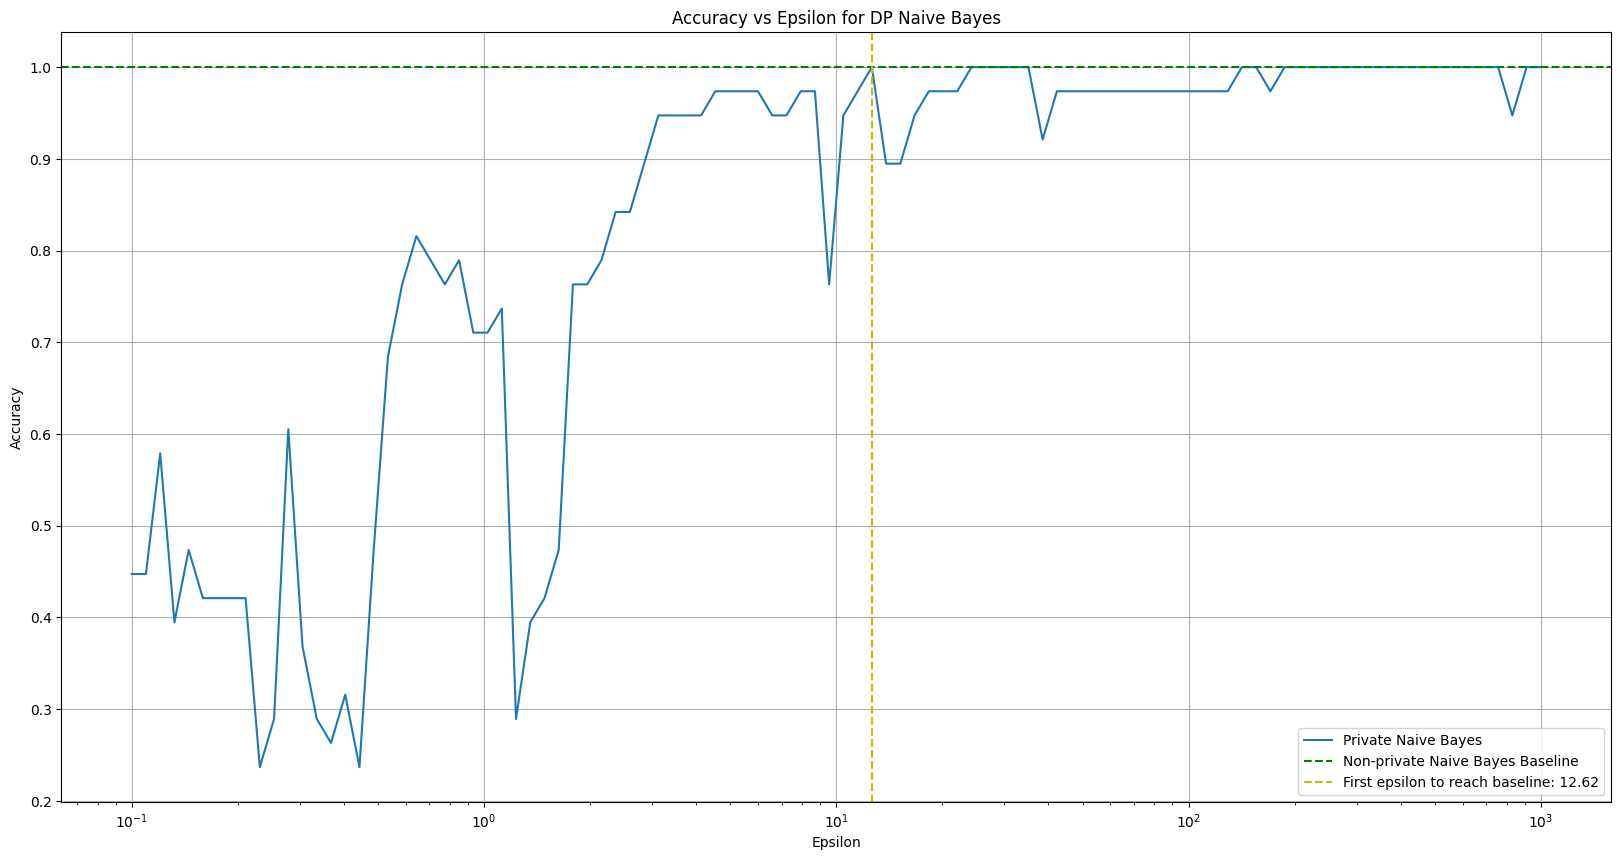

In [8]:
nonPrivateBaseline = skAcc

epsilons = np.logspace(-1, 3, 100)

privAccs = []

for epsilon in epsilons:
  currClf = dpGaussianNB(bounds=bounds, epsilon=epsilon, random_state=0)
  currClf.fit(X_train, y_train)
  currPreds = currClf.predict(X_test)
  currAcc = accuracy_score(y_test, currPreds)
  privAccs.append(currAcc)

plt.figure(figsize=(20, 10))

plt.plot(epsilons, privAccs, label="Private Naive Bayes")

plt.axhline(y=nonPrivateBaseline, color='g', linestyle='--', label="Non-private Naive Bayes Baseline")

firstToBaseline = epsilons[np.argmax(np.array(privAccs) >= nonPrivateBaseline)]
plt.axvline(x=firstToBaseline, color='y', linestyle='--', label=f"First epsilon to reach baseline: {firstToBaseline:.2f}")

plt.xlabel("Epsilon")
plt.ylabel("Accuracy")

plt.xscale("log")

plt.title("Accuracy vs Epsilon for DP Naive Bayes")

plt.legend()
plt.grid()

plt.show()


The first $\epsilon$ value that fully approximates the non-private model is $\epsilon=12.62$. But as we can see, starting from $\epsilon\geq3$, the accuracy of the DP-Model is already very good and close to the non-private model (above 90%). This is because the model is trained with a higher $\epsilon$ value, which makes it easier for the model to learn the underlying patterns in the data due to the lower amount of noise added.

#### c) Set an initial privacy budget using BudgetAccountant object. Choose three different queries to apply to the DP-Model, and measure the changes in the privacy budget after each query. Does the privacy loss vary based on the query? How much?

In [9]:
budgetAccountant = BudgetAccountant(epsilon=4)

privClf = dpGaussianNB(bounds=bounds, accountant=budgetAccountant, epsilon=3, random_state=0)

print(f"Budget before fitting: {budgetAccountant.remaining()}")

privClf.fit(X_train, y_train)

print(f"Budget after fitting: {budgetAccountant.remaining()}")

privPreds = privClf.predict(X_test)

print(f"Budget after predicting: {budgetAccountant.remaining()}")

privAcc = accuracy_score(y_test, privPreds)

print(f"Budget after calculating accuracy: {budgetAccountant.remaining()}")

print(f"Private Naive Bayes Accuracy: {privAcc}")

Budget before fitting: (epsilon=4.0, delta=1.0)
Budget after fitting: (epsilon=1.0, delta=1.0)
Budget after predicting: (epsilon=1.0, delta=1.0)
Budget after calculating accuracy: (epsilon=1.0, delta=1.0)
Private Naive Bayes Accuracy: 0.9473684210526315


As we can see the only query that affects the privacy budget is the `fit` query. The model creation, `predict` query and accuracy calculation do not affect the privacy budget. The privacy loss happens when the `fit` query is executed, and the privacy budget is reduced by the $\epsilon$ defined during the model creation. This is because the `fit` query is the only query that adds noise to the model in order to make it differentially private.